<a href="https://colab.research.google.com/github/YosserAkili/Sentiment-Analysis/blob/main/Sentiment_Analysis_For_Financial_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis For Financial News

# Matière : Intelligence Artificielle

# I. Description

The context of this project revolves around sentiment analysis in the financial domain using the "FinancialPhraseBank" dataset. This dataset has been designed to evaluate the sentiments of financial news headlines from the perspective of an individual investor. The dataset consists of two main columns:

**Target Variable Sentiment (Sentiment):** This column represents the sentiment associated with each financial news headline. Sentiments can be classified into three main categories: negative, neutral, or positive. This label is assigned based on the overall opinion expressed in the headline.

**News Headline:** This column contains the headlines of financial news. Each row in this column represents a specific news headline, typically drawn from financial news sources. These headlines are real examples of financial news as presented to investors.

**Goal:** To leverage this data for sentiment analysis in the financial domain.

This dataset provides an opportunity to better understand how financial news is perceived by individual investors, and it can have applications in investment decision-making, competitive intelligence, or financial market forecasting.


# II. Importations

In [ ]:
import pandas as pd
import numpy as np
!pip install cufflinks
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, f1_score,confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.preprocessing  import LabelEncoder
le = LabelEncoder()
import warnings
warnings.filterwarnings("ignore")
import missingno as miss
from collections import Counter
import plotly.express as px
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
from tqdm import tqdm
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, MaxPooling1D, Conv1D, Concatenate, Bidirectional, GlobalMaxPool1D, ActivityRegularization, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import tensorflow as tf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yosr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yosr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yosr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# II. Database:

In [ ]:
with open("all-data.csv", 'rb') as file:
    text = file.read().decode('utf-8', 'ignore')
with open("decoded-all-data.csv", 'w', encoding='utf-8') as decoded_file:
    decoded_file.write(text)


In [ ]:
df = pd.read_csv("decoded-all-data.csv", names=["sentiment","news_headline"],encoding="utf-8")

df

,sentiment,news_headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


# IV. EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment      4846 non-null   object
 1   news_headline  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


<Axes: >

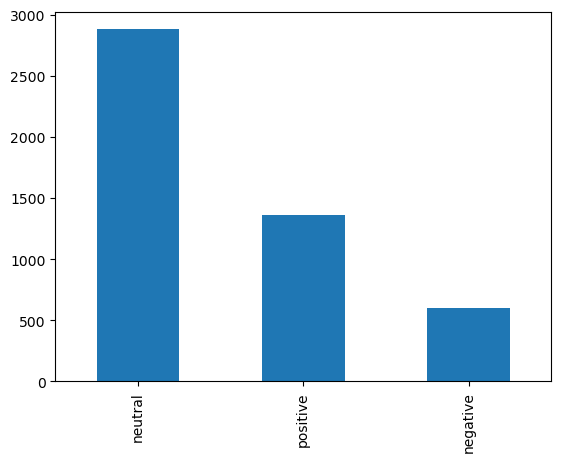

In [ ]:
df['sentiment'].value_counts().plot(kind='bar')

<Axes: ylabel='sentiment'>

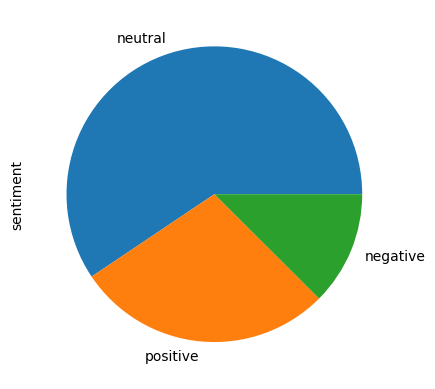

In [ ]:
df['sentiment'].value_counts().plot(kind='pie')

# V. Pre-processing:

This Python function takes a list of texts as input and returns tokenized word sequences after performing preprocessing steps such as converting to lowercase, removing special characters and numbers, eliminating stopwords, and lemmatization.

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer


def get_sequences(text):
    # Create a tokenizer object
    text = [t.lower() for t in text]

    # Remove special characters and digits
    for i in range(len(text)):
        text[i] = re.sub(r'[^a-zA-Z\s]', '', text[i])
        #Cette boucle parcourt chaque texte dans la liste et utilise une expression
        #régulière (re.sub) pour supprimer tous les caractères spéciaux et les chiffres, ne laissant que les lettres et
        #les espaces.
        # Cette partie utilise la bibliothèque NLTK pour supprimer les mots d'arrêt (stopwords) de chaque texte,
        #ce qui permet de réduire le bruit inutile dans le texte.
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]
    lemmatizer = WordNetLemmatizer()

    # réduction d'un mot à sa forme de base en gardant le sens
    lemmatized_sequences = [[lemmatizer.lemmatize(word) for word in word_tokenize(sentence)] for sentence in text]

    #Ces lignes créent un objet Tokenizer de Keras, qui convertira les mots en nombres.
    #Ensuite, la méthode fit_on_texts est utilisée pour ajuster le tokenizer aux séquences lemmatisées,
    #ce qui crée un mapping de mots à des entiers.
    tokenizer = Tokenizer()

    # Fit the tokenizer on text to convert words into numbers
    tokenizer.fit_on_texts(lemmatized_sequences)
        # Get the word-to-number mapping
        #le mapping est basé sur l'occurrence des mots dans le corpus de textes que j'utilise pour l'ajuster.
    sequences = tokenizer.texts_to_sequences(lemmatized_sequences)




    # Cette ligne calcule la longueur maximale de toutes les séquences en prenant la séquence la plus longue.
    max_sequence_length = np.max(list(map(lambda x: len(x), sequences)))

    #Enfin, cette partie utilise la fonction pad_sequences de Keras pour ajouter du rembourrage (zéros) à la fin de
    #chaque séquence, de manière à ce que toutes les séquences aient la même longueur
    sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    print(max_sequence_length)
    return sequences

This function is useful for preparing data for training machine learning models for sentiment classification of financial news headlines. It helps split the data into a training set and a test set, and preprocesses them to make them compatible with deep learning models.







In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    sequences = get_sequences(df['news_headline'])

    label_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }

    y = df['sentiment'].replace(label_mapping)

    train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, y, train_size=0.8, shuffle=True, random_state=42)

    return train_sequences, test_sequences, y_train, y_test


In [ ]:
train_sequences, test_sequences, y_train, y_test=preprocess_inputs(df)

50


In [ ]:
train_sequences

array([[  3, 126, 691, ...,   0,   0,   0],
       [243, 507, 584, ...,   0,   0,   0],
       [  1,  11, 240, ...,   0,   0,   0],
       ...,
       [ 52, 238, 265, ...,   0,   0,   0],
       [  1, 624,  12, ...,   0,   0,   0],
       [462, 166, 840, ...,   0,   0,   0]])

In [ ]:
test_sequences

array([[   1,   11,   30, ...,    0,    0,    0],
       [5783, 5784,  118, ...,    0,    0,    0],
       [   3, 2226, 1712, ...,    0,    0,    0],
       ...,
       [1286,  292,   13, ...,    0,    0,    0],
       [ 878,  234,   78, ...,    0,    0,    0],
       [ 644,  113,  252, ...,    0,    0,    0]])

In [ ]:
y_train

432     1
3071    1
289     2
2588    1
4121    1
       ..
4426    0
466     2
3092    1
3772    1
860     2
Name: sentiment, Length: 3876, dtype: int64

# Models

## 1. RNN : GRU

A Recurrent Neural Network (RNN) model is a type of artificial neural network specifically designed to handle sequential data, such as sequences of text, sound, time, etc. Unlike traditional feedforward neural networks, RNNs are designed to account for the temporal structure of data by processing sequences step by step.

The **GRU (Gated Recurrent Unit)**  is a variant of RNN designed to address gradient issues in traditional RNNs. The GRU introduces two gates, known as "gate," in English, which control the flow of information within the network. These gates are as follows:

Reset Gate: This gate determines which parts of the previous memory state should be forgotten or updated. It helps manage long dependencies in the sequence more effectively.

Update Gate: This gate determines which parts of the current memory should be updated with new information. It allows the model to "decide" which information is crucial to retain.

**Operating:** When the Gated Recurrent Unit (GRU) processes a sequence, it considers the current input, the previous state of the memory, and the decisions made by the reset and update gates. Based on these components, the GRU updates its internal state (memory) and produces an output. This output is typically a representation of the processed sequence.

In [ ]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
    #Elle permet de représenter les mots sous forme de vecteurs numériques. Les mots sont associés à des vecteurs dans
    #un espace vectoriel continu. Dans votre cas, il y a 10 123 mots différents dans le vocabulaire, et chaque mot sera
    #représenté par un vecteur de 128 dimensions. La longueur maximale des séquences est définie par input_length.
x = tf.keras.layers.Embedding(input_dim = 10123,
                             output_dim = 128,
                             input_length = train_sequences.shape[1])(inputs)
    #Elle est capable de prendre en compte la séquence d'entrée et de mémoriser des informations précédentes grâce à
    #des unités récurrentes. il y a 256 unités GRU. L'activation 'tanh' (tangente hyperbolique)
    #est utilisée pour les unités GRU. La spécification return_sequences=True signifie que cette couche renverra
    #des séquences au lieu d'une seule valeur.
x = tf.keras.layers.GRU(256, return_sequences =True, activation = 'tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x) #obtenir des probabilités pour chaque classe.

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])
history = model.fit(train_sequences,
                   y_train,
                   validation_split =  0.2,
                   batch_size = 32,
                   epochs = 100,
                   callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                                patience = 3,
                                                                restore_best_weights = True)])

Epoch 1/100
97/97 [==============================] - 7s 56ms/step - loss: 0.8339 - accuracy: 0.6342 - val_loss: 0.7773 - val_accuracy: 0.6701
Epoch 2/100
97/97 [==============================] - 4s 46ms/step - loss: 0.4577 - accuracy: 0.8171 - val_loss: 0.6722 - val_accuracy: 0.7178
Epoch 3/100
97/97 [==============================] - 4s 43ms/step - loss: 0.1685 - accuracy: 0.9455 - val_loss: 0.8219 - val_accuracy: 0.7216
Epoch 4/100
97/97 [==============================] - 4s 43ms/step - loss: 0.0664 - accuracy: 0.9813 - val_loss: 1.2791 - val_accuracy: 0.7255
Epoch 5/100
97/97 [==============================] - 5s 52ms/step - loss: 0.0432 - accuracy: 0.9890 - val_loss: 1.2216 - val_accuracy: 0.7229


In [ ]:
results = model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

Test Losss: 0.62598
Test accuracy: 74.63918%


## 2. LSTM

LSTM, which stands for "Long Short-Term Memory" in English, is a type of recurrent neural network (RNN) used in deep learning. Recurrent neural networks are neural network models designed to process sequential data, where the order of elements in the sequence is important.

LSTM is a special variant of RNN designed to better handle the issue of long-term dependency in sequences. Unlike traditional RNNs, which may struggle to learn long-term relationships in sequential data due to the "vanishing gradient" phenomenon, LSTMs have been engineered to capture these long-term dependencies more effectively.

LSTMs use a cell structure with gates to regulate the flow of information through the network. These gates enable LSTMs to memorize important information over long sequences while forgetting less important information. Key components of an LSTM cell include:

Cell State: This is the long-term memory of the cell. It can retain important information throughout the sequence.

Hidden State: This is the cell's output at a given moment, which may contain useful information for the task at that time.

Gates: Gates are mechanisms that control the flow of information into and out of the cell. There are three types of gates in an LSTM cell:

* Forget Gate: Controls what should be forgotten or retained in the cell's memory.
* Input Gate: Controls the information to be added to the cell's memory.
* Output Gate: Controls the cell's output at a given moment.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

* The model is defined using the Sequential API of Keras.
* It is compiled with the Adam optimizer, the "sparse_categorical_crossentropy" loss function (suitable for multiclass classification), and the accuracy metric.
* An early stopping callback is employed to monitor the loss on the validation set and halt training if the loss does not improve for a certain number of epochs (defined by patience).
* The model is then trained on the training data with a batch size of 64, for a maximum of 100 epochs.
* Finally, the model is evaluated on the test data, and the model's accuracy on the test set is displayed.

In [ ]:
model1 = Sequential([

    Embedding(input_dim=10123, output_dim=128, input_length=train_sequences.shape[1]),

    Bidirectional(LSTM(256, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model1.fit(train_sequences, y_train,
                    validation_split=0.2,
                    batch_size=64,
                    epochs=100,
                    callbacks=[early_stopping])

test_loss, test_accuracy = model1.evaluate(test_sequences, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/100
49/49 [==============================] - 28s 373ms/step - loss: 7.6141 - accuracy: 0.5894 - val_loss: 2.3114 - val_accuracy: 0.6366
Epoch 2/100
49/49 [==============================] - 15s 300ms/step - loss: 1.2098 - accuracy: 0.7155 - val_loss: 0.9001 - val_accuracy: 0.6817
Epoch 3/100
49/49 [==============================] - 15s 315ms/step - loss: 0.5509 - accuracy: 0.8016 - val_loss: 0.9789 - val_accuracy: 0.6740
Epoch 4/100
49/49 [==============================] - 15s 298ms/step - loss: 0.4332 - accuracy: 0.8394 - val_loss: 1.0270 - val_accuracy: 0.6662
Epoch 5/100
49/49 [==============================] - 15s 297ms/step - loss: 0.3762 - accuracy: 0.8552 - val_loss: 1.0868 - val_accuracy: 0.6314
Epoch 6/100
49/49 [==============================] - 17s 340ms/step - loss: 0.3494 - accuracy: 0.8610 - val_loss: 1.3232 - val_accuracy: 0.6469
Epoch 7/100
49/49 [==============================] - 17s 340ms/step - loss: 0.3253 - accuracy: 0.8797 - val_loss: 1.3667 - val_accuracy:

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Votre modèle préalablement défini


def pred(text):
   # Tokenization
    tokens = word_tokenize(text)

    # Stop words removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Convert lemmatized tokens to sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lemmatized_tokens)
    sequences = tokenizer.texts_to_sequences([lemmatized_tokens])
    sequences = np.array(sequences)
    sequences =sequences.reshape(1, -1)
    # Pad the sequences with the correct maximum length
    sequences = pad_sequences(sequences, maxlen=50, padding='post')



    # Faire la prédiction
    predicted_sentiment = model.predict(sequences)

    # Traduire la prédiction en une classe (positive, negative, ou neutral)
    sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_class = sentiment_mapping[np.argmax(predicted_sentiment)]

    # Afficher la prédiction
    print("Predicted Sentiment:", predicted_class)
    return predicted_class

### neutre

In [ ]:
pred( "According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .")

1/1 [==============================] - 0s 388ms/step
Predicted Sentiment: neutral


'neutral'

### Positive

In [ ]:
pred("According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .")

1/1 [==============================] - 0s 43ms/step
Predicted Sentiment: positive


'positive'

### Négative

In [ ]:
pred("McDonald's sales disappoint, as the company struggles to attract new customers.")

1/1 [==============================] - 0s 26ms/step
Predicted Sentiment: neutral


'neutral'

In [ ]:
pred("Banks report strong earnings, but investors remain cautious")

1/1 [==============================] - 0s 26ms/step
Predicted Sentiment: neutral


'neutral'

One can observe that the "neutral" class is dominant, containing almost 3000 news, while the "positive" class has 1500, and the "negative" class has 500. This result is confirmed by the prediction outcomes; the models used are unable to capture the negative class.